In [210]:
from collections import defaultdict
import copy
import matplotlib.pyplot as plt
import networkx as nx
import sys

In [212]:
class Vertex:
    """Vertex."""

    def __init__(self, label) -> None:
        self.label = label


class Graph:
    """Graph."""

    def __init__(self, paths, directed=False) -> None:
        """Initialize a undirected graph by default."""
        self._vgraph = nx.DiGraph() if directed else nx.Graph() 
        self._graph = defaultdict(set)
        self._directed = directed
        self._vertices = set()
        self.add_paths(paths)

    def size(self):
        """Return size of graph."""
        return len(self._graph)

    def add_paths(self, paths) -> None:
        """Add paths to graph."""
        for vertex_one, vertex_two, weight in paths:
            self.add(vertex_one, vertex_two, weight)

    def add(self, vertex_one, vertex_two, weight) -> None:
        """Add connection between vertex_one and vertex_two """
        self._graph[vertex_one].add((vertex_two, weight))
        self._vgraph.add_edge(vertex_one, vertex_two, weight=weight)
        self._vertices.add(vertex_one)
        self._vertices.add(vertex_two)
        if not self._directed:
            self._graph[vertex_two].add((vertex_one, weight))
            self._vgraph.add_edge(vertex_two, vertex_one, weight=weight)

    def remove(self, vertex) -> None:
        """Remove all references to the passed vertex."""
        for n, cxns in self._graph.items():
            try:
                cxns.remove(vertex)
            except KeyError:
                pass
        try:
            del self._graph[vertex]
        except KeyError:
            pass
        self._vgraph.remove_edges_from(vertex)
        self._vgraph.remove_node(vertex)

    def is_connected(self, vertex_one, vertex_two) -> bool:
        """Return boolean True if vertex_one directly connected to vertex_two."""
        return vertex_one in self._graph and vertex_two in self._graph[vertex_one]

    def find_path(self, vertex_one, vertex_two, path=[]) -> list:
        """Return a path between vertex_one and vertex_two."""
        path = path + [vertex_one]
        if vertex_one == vertex_two:
            return path
        if vertex_one not in self._graph:
            return None
        for vertex in self._graph[vertex_one]:
            if vertex not in path:
                new_path = self.find_path(vertex, vertex_two, path)
                if new_path:
                    return new_path
        return []

    def get_weight(self, vertex_one, vertex_two) -> int:
        """Return the weight of the edge between two vertices."""
        for edge in self._graph[vertex_one]:
            if edge[0] == vertex_two[0]:
                return edge[1]

    def save(self) -> object:
        """Return a deepcopy of this graph."""
        return copy.deepcopy(self)

    def __str__(self) -> str:
        """Return string representation of Graph."""
        return f'{self.__class__.__name__}({dict(self._graph)})'


    def prim_jarnik(self) -> list:
        """
        Return the cost of a MST of provide graph or this graph.
        Algorithm inspiration using a priority queue from:
        https://algotree.org/algorithms/minimum_spanning_tree/prims_python/

        Runtime: O(M + n log n)
        """
        # start at the first node
        v_start = list(self._graph.keys())[0]
        # first node points at itself so it is 0
        pq = {Vertex(v_start): 0}
        added = {k: False for k in self._graph.keys()}
        min_span_tree_cost = 0

        while pq:
            # Choose the adjacent node with the least edge cost
            min_weight_adj_vertex = min(pq, key=pq.get)
            cost = pq[min_weight_adj_vertex]
            # Remove the min_weight_adj_vertex from the priority queue
            del pq[min_weight_adj_vertex]
     
            if added[min_weight_adj_vertex.label] == False:
                min_span_tree_cost += cost
                added[min_weight_adj_vertex.label] = True
                print(f'Added vertex: {min_weight_adj_vertex.label} to PriorityQueue, weight: {cost}, cost now: {str(min_span_tree_cost)}')
                
                for adj_vertex in self._graph[min_weight_adj_vertex.label]:
                    new_vertex = Vertex(adj_vertex[0])
                    adj_weight = self.get_weight(min_weight_adj_vertex.label, adj_vertex)

                    if added[new_vertex.label] == False:
                        pq[new_vertex] = adj_weight
        return min_span_tree_cost

    def _create_edges_from_djikstra(self, path_list) -> list:
        """Return list of tuples from dict."""
        edges = []
        for start, markers in path_list.items():
            edges.append((start, markers[0]))
        return edges

    def get_min_distance(self, min_vertex, dist, shortest_path):
        """Return the vertex with the minimum distance value."""
        # Initialize minimum distance for next node
        min = sys.maxsize
        # min_vertex = src_vertex
        # Search any vertex that isn't the nearest one
        # and that is not in the shortest path tree
        for vertex in dist.keys():
            if dist[vertex] < min and shortest_path[vertex] == False:
                min = dist[vertex]
                min_vertex = vertex
        return min_vertex

    def djikstra(self, src_vertex):
        """
        Return the shortest paths to every vertex provided src vertex.
        Runtime: O(n^2)
        """
        dist = {k: sys.maxsize for k in self._graph.keys()}
        dist[src_vertex] = 0
        shortest_path = {k: False for k in self._graph.keys()}
        queue = [v for v in self._graph.keys()]
        # for visualization
        path_to = {v: [] for v in self._vertices}
        path_to[src_vertex]= src_vertex

        while queue:
            vertex = queue.pop(0)
            # Get the min distance vertex from unprocessed vertices
            min_dist_vertex = self.get_min_distance(src_vertex, dist, shortest_path)
            # mark processed
            shortest_path[min_dist_vertex] = True
            # Update the distance value of the adjacent vertices
            # of the picked vertex only if the current
            # distance > new distance and
            # the vertex has not been processed
            for edge in self._graph[vertex]:
                curr_vertex, curr_weight = edge
                if (shortest_path[curr_vertex] == False and dist[curr_vertex] > dist[vertex] + curr_weight):
                    dist[curr_vertex] = dist[vertex] + curr_weight
                    path_to[curr_vertex] = vertex          
        return dist, self._create_edges_from_djikstra(path_to)

    def _create_edges_from_DAG(self, paths):
        """Return a list of tuples from path object for DAG."""
        edges = []
        for start, markers in paths.items():
            # iterate but stop before the second to last item in the list
            for i in range(len(markers) - 2):
                edges.append((markers[i], markers[i + 1]))
            # add the final path to the end node
            edges.append((markers[-1], start))
        return edges

    def topo_sort(self, vertex, visited, stack):
        """Return a topological sort of the graph."""
        # Mark node as visited.
        visited[vertex] = True
        
        if vertex in self._graph.keys():
            for edge in self._graph[vertex]:
                if visited[edge[0]] == False:
                    self.topo_sort(edge[0], visited, stack)
 
        # Add to Toposort
        stack.append(vertex)

    def shortest_path_DAG(self, start_vertex):
        """
        Return the shortest path to each vertex in the graph from the source vertex.
        Runtime: O(n) for the DFS and O(n^2) for the shortest path so O(n^3)
        """
        if not self._directed:
            print('This is not a directed graph so this method is not supported.')
        
        visited = {label: False for label in self._vertices}
        stack = []
        # for visualization
        path_to = {v: [] for v in self._vertices}
        path_to[start_vertex].append(start_vertex) 
  
        for v in self._vertices:
            if visited[v] == False:
                self.topo_sort(start_vertex, visited, stack)

        # Initialize distances to all vertices as infinite
        dist = {v: sys.maxsize for v in self._vertices}
        dist[start_vertex] = 0
        prev_vertex = None
 
        while stack:
            # Get the next vertex from topological order
            vertex = stack.pop()
            # Update distances of all adjacent vertices
            for edge in self._graph[vertex[0]]:
                if dist[edge[0]] > dist[vertex[0]] + edge[1]:
                    # algorithm code
                    dist[edge[0]] = dist[vertex[0]] + edge[1]
                    # visualization pathway tracking code
                    prev_adj_list = [v_label[0] for v_label in self._graph[prev_vertex]]
                    # if the prev vertex has a path to this edge
                    # and that vertex is not the start_vertex
                    # then replace the vertex in path_to with the
                    # vertex that provides the shorter path
                    if prev_vertex != start_vertex and edge[0] in prev_adj_list and len(path_to[edge[0]]) > 1:
                        path_to[edge[0]][-1] = vertex
                    else:
                        path_to[edge[0]].append(vertex)
            
            prev_vertex = vertex
        return dist, self._create_edges_from_DAG(path_to)

    def show(self, path_list=None) -> None:
        """Show the graph. If an mst_path is provided then show that path and relaxed edges."""
        fig, ax = plt.subplots()
        pos = nx.circular_layout(self._vgraph)
        # vertices
        nx.draw_networkx_nodes(self._vgraph, pos, node_size=700)
        # edges
        if path_list:
            nx.draw_networkx_edges(self._vgraph, pos, edgelist=path_list, width=6)

            relaxed = []
            for edge in self._vgraph.edges:
                if edge not in path_list:
                    relaxed.append(edge)
            nx.draw_networkx_edges(
                    self._vgraph, pos, edgelist=relaxed, width=6, alpha=0.5, edge_color="b", style="dashed"
                )
        else:
            nx.draw_networkx_edges(self._vgraph, pos, edgelist=self._vgraph.edges(), width=6)
        # vertex labels
        nx.draw_networkx_labels(self._vgraph, pos, font_size=20, font_family="sans-serif")
        # edge weight labels
        edge_labels = nx.get_edge_attributes(self._vgraph, "weight")
        nx.draw_networkx_edge_labels(self._vgraph, pos, edge_labels)

        ax = plt.gca()
        ax.margins(0.08)
        ax.axis("off")
        fig.tight_layout()

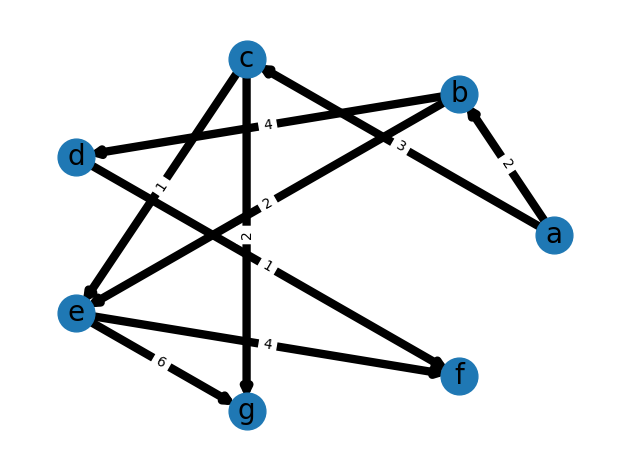

In [213]:
edges = [
   ('a', 'b', 2),
   ('a', 'c', 3),
   ('b', 'd', 4),
   ('b', 'e', 2),
   ('c', 'e', 1),
   ('c', 'g', 2),
   ('d', 'f', 1),
   ('e', 'f', 4),
   ('e', 'g', 6)   
]
acyclic_dag = Graph(edges, directed=True)
acyclic_dag.show()

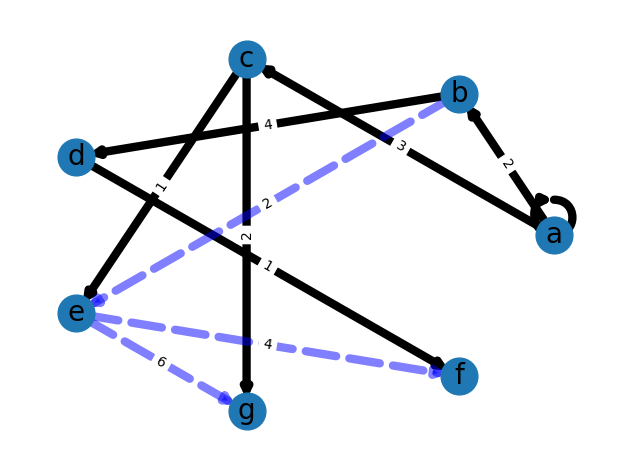

In [217]:
distances, shorest_paths = acyclic_dag.shortest_path_DAG(start_vertex)
acyclic_dag.show('a')

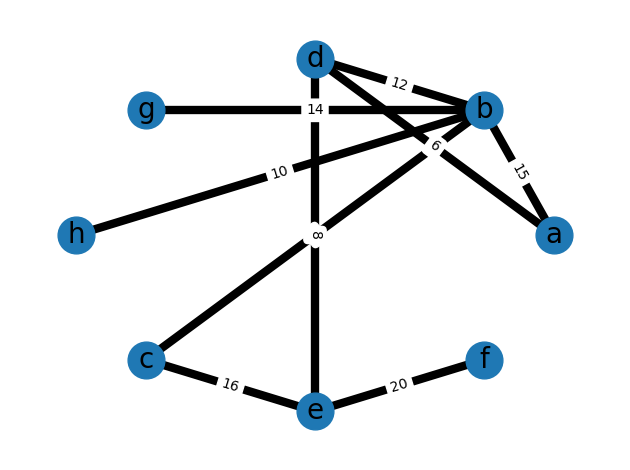

In [218]:
# example taken from 17.4.1 in zybooks
undirected_graph = Graph([
    ('a', 'b', 15),
    ('a', 'd', 6),
    ('b', 'd', 12),
    ('b', 'g', 14),
    ('b', 'h', 10),
    ('b', 'c', 9),
    ('c', 'e', 16),
    ('d', 'e', 8),
    ('e', 'f', 20),
])
undirected_graph.show()

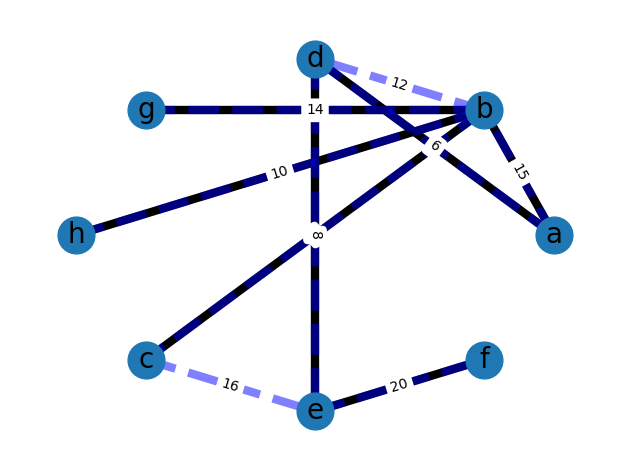

In [219]:
distances, paths = undirected_graph.djikstra('a')
undirected_graph.show(paths)

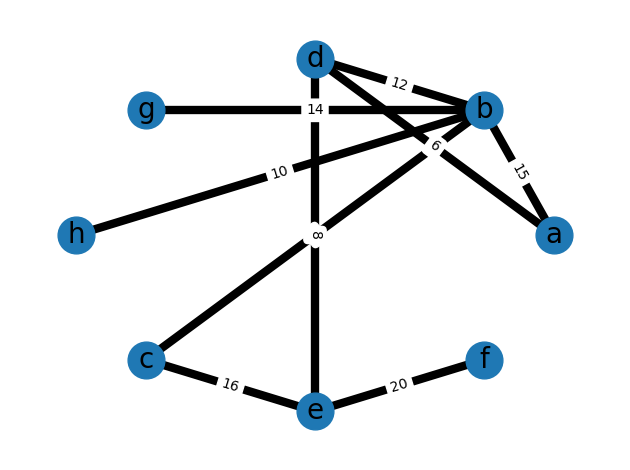

In [220]:
undirected_graph_two = Graph([
    ('a', 'b', 15),
    ('a', 'd', 6),
    ('b', 'd', 12),
    ('b', 'g', 14),
    ('b', 'h', 10),
    ('b', 'c', 9),
    ('c', 'e', 16),
    ('d', 'e', 8),
    ('e', 'f', 20),
])
undirected_graph_two.show()

Added vertex: a to PriorityQueue, weight: 0, cost now: 0
Added vertex: d to PriorityQueue, weight: 6, cost now: 6
Added vertex: e to PriorityQueue, weight: 8, cost now: 14
Added vertex: b to PriorityQueue, weight: 12, cost now: 26
Added vertex: c to PriorityQueue, weight: 9, cost now: 35
Added vertex: h to PriorityQueue, weight: 10, cost now: 45
Added vertex: g to PriorityQueue, weight: 14, cost now: 59
Added vertex: f to PriorityQueue, weight: 20, cost now: 79
Minimum Spanning Tree Cost: 79


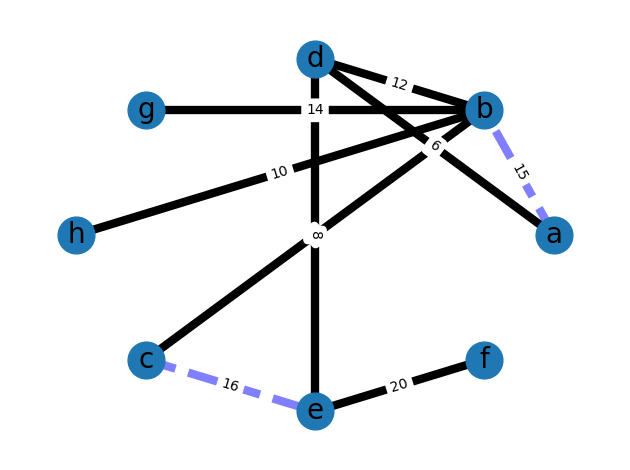

In [221]:
mst_cost = undirected_graph_two.prim_jarnik()
print(f'Minimum Spanning Tree Cost: {mst_cost}')
# Below is the mst path which can be visually verified to be the same as the algorithm
# I was unable to produce a similar path matching as in some of the other algorithms
# but the terminal output shows the iterations.
undirected_graph_two.show([
    ('a', 'd'),
    ('b', 'd'),
    ('b', 'g'),
    ('b', 'h'),
    ('b', 'c'),
    ('d', 'e'),
    ('e', 'f'),
])